<a href="https://colab.research.google.com/github/Ssurf777/GAN_sample/blob/main/sample_VAE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# プロダクト開発

DCGAN(Deep Convolutional GAN)＋VAEを用いて画像生成を行う


In [ ]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # ライブラリのインストール
    !pip install torch==2.1.1 torchvision==0.16.1
else:
    print("Not Google Colab")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

# Liblary import & Data Import

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import HTML
from torchvision import datasets, transforms
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
num_epochs = 10  # エポック数を定義
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# データセットの読み込みとフィルタリング
dataset_train = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# planeとcarのデータのみを使用
X, y = [], []
for data in tqdm(dataset_train):
    if data[1] in [0, 1]:  # plane(0), car(1)
        X.append(data[0].numpy())
        y.append(data[1])
X = torch.tensor(np.array(X), dtype=torch.float32)  # numpy配列に変換してからテンソル化
y = torch.tensor(y, dtype=torch.long)

dataset_train = torch.utils.data.TensorDataset(X, y)
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=2
)


100%|██████████| 170M/170M [00:03<00:00, 54.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 50000/50000 [00:14<00:00, 3365.66it/s]


torch.Size([64, 3, 32, 32])


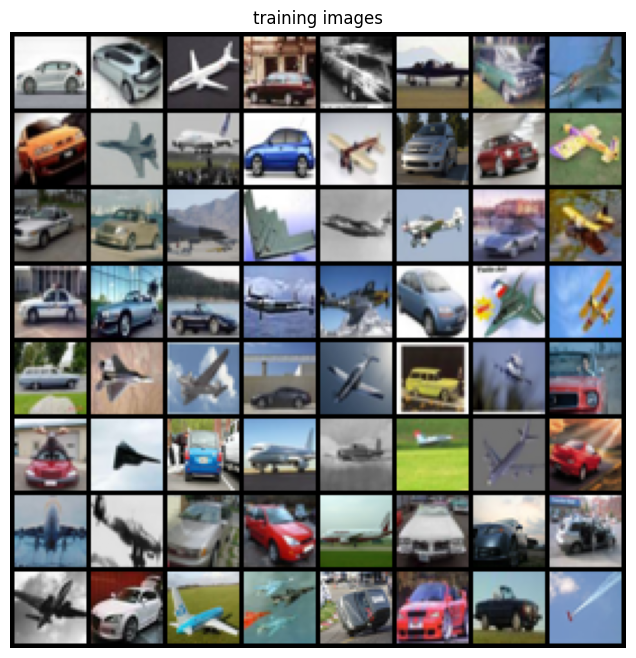

In [ ]:
# データの確認
batch = next(iter(dataloader_train))
print(batch[0].shape)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("training images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            batch[0].to(device)[:batch_size], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# VAE-GAN Encoder Decoder Discriminator Define
## VAE-GANを構築します
* VAEのEncoderとDecoderはDCGANと同様にCNNと転置畳み込みを活用
* 潜在変数zは2次元とする
* DiscriminatorはDCGANと同様にCNNを活用

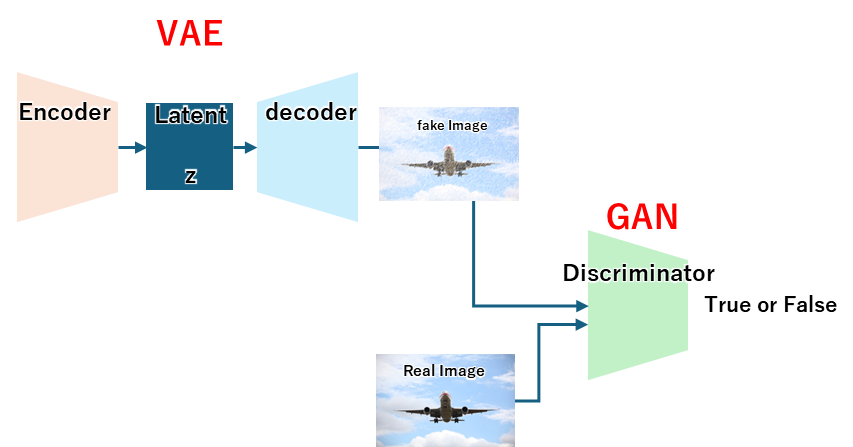

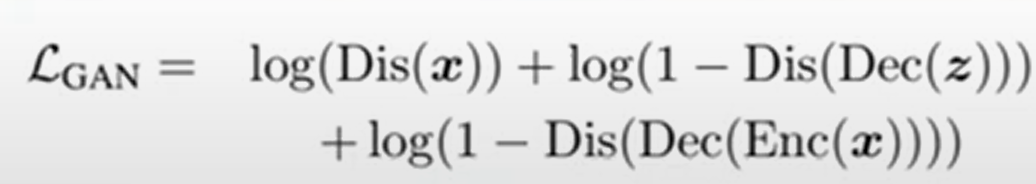

In [ ]:
# 重みの初期化を行う関数
def weights_init(m):

    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 入力: 3x32x32 -> 出力: 64x16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 出力: 128x8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 出力: 256x4x4
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_mean = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # デコーダ用の全結合層（latent_dim -> 256 * 4 * 4）
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)

        # デコーダのアップサンプリング部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 修正: 256 -> fc_decodeの出力チャンネル
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 出力: 64x16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 出力: 3x32x32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)  # 畳み込み層を通す
        h = h.view(h.size(0), -1)  # フラット化
        mu = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)  # 再パラメータ化トリック
        h_decoded = self.fc_decode(z).view(-1, 256, 4, 4)  # フラットな潜在変数をデコード層の入力にリシェイプ
        return self.decoder(h_decoded), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    # x と recon_x は torch.Size([64, 3, 32, 32]) の形状
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

class Discriminator(nn.Module):
    def __init__(self, channel_size, feature_size):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channel_size, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.net(input).view(-1, 1).squeeze(1)


# Training

In [ ]:

# データの設定
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)

# パラメータの設定
input_dim = 32 * 32 * 3  # CIFAR-10の画像サイズに対応
latent_dim = 2
feature_sizeD = 64
num_epochs = 10

# モデルとオプティマイザの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelG = VAE(latent_dim).to(device)
modelD = Discriminator(3, feature_sizeD).to(device)

# weights_init関数を適用して重みを初期化する
modelG.apply(weights_init)
modelD.apply(weights_init)

vae_optimizer = optim.Adam(modelG.parameters(), lr=0.0002)
discriminator_optimizer = optim.Adam(modelD.parameters(), lr=0.0002)

G_losses, D_losses = [], []
img_list=[]
iters = 0

start_time = time.time()  # 学習全体の開始時間
# トレーニングループ
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # エポックの開始時間
    for i, (real_data, _) in enumerate(dataloader_train):  # 修正：iを取得

        real_data = real_data.to(device)
        batch_size = real_data.size(0)  # バッチサイズの動的な取得
        #print(real_data.shape)
        # VAEのフォワードパス
        reconstructed_data, mu, logvar = modelG(real_data)
        vae_loss = vae_loss_function(reconstructed_data, real_data, mu, logvar)

        # VAEのパラメータ更新
        vae_optimizer.zero_grad()
        vae_loss.backward()
        vae_optimizer.step()
        # ランダムノイズを生成
        latent = torch.randn(batch_size, latent_dim).to(device)  # [batch_size, latent_dim]

        # fc_decode を使ってデコーダが期待する形状に変換
        latent = modelG.fc_decode(latent)  # 全結合層で変換
        latent = latent.view(batch_size, 256, 4, 4)  # デコーダが期待する形状にリシェイプ

        # デコーダを通して生成データを取得
        fake_data = modelG.decoder(latent).detach()
        fake_data = fake_data.view(-1, 3, 32, 32)  # Discriminator 入力のためのリシェイプ



        # Discriminatorのフォワードパス
        real_output = modelD(real_data)
        fake_output = modelD(fake_data)

        # サイズを揃える
        if real_output.size(0) != fake_output.size(0):
            fake_output = fake_output[:real_output.size(0)]

        d_loss = -torch.mean(torch.log(real_output + 1e-8) + torch.log(1 - fake_output + 1e-8))

        # Discriminatorのパラメータ更新
        discriminator_optimizer.zero_grad()
        d_loss.backward()
        discriminator_optimizer.step()

        # Generator（デコーダ）を本物に近づける
        fake_data_for_g = modelG.decoder(latent).detach()
        fake_data_for_g = fake_data_for_g.view(-1, 3, 32, 32)  # Discriminator入力のためのリシェイプ
        fake_output_for_g = modelD(fake_data_for_g)
        gan_loss = -torch.mean(torch.log(fake_output_for_g + 1e-8))

        # デコーダのパラメータ更新
        vae_optimizer.zero_grad()
        gan_loss.backward()
        vae_optimizer.step()

        # 損失を保存
        G_losses.append(gan_loss.item())
        D_losses.append(d_loss.item())
        iters += 1

        # fixed_noiseによる G の出力を保存し、生成器の精度を確認します
        if (iters % 100 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader_train) - 1)
        ):
            with torch.no_grad():
                # latentの生成を確認
                #fixed_noise = torch.randn(batch_size, latent_dim).to(device)  # ランダムノイズ
                fake = modelG.decoder(latent).detach().view(-1, 3, 32, 32)  # デコーダを通して生成
                # img_listに生成画像を追加
                img_list.append(
                    torchvision.utils.make_grid(fake, padding=2, normalize=True)
                )

    # エポックの経過時間を計算
    epoch_time = time.time() - epoch_start_time
    # 全体の経過時間
    elapsed_time = time.time() - start_time
    # 残りのエポック数
    remaining_epochs = num_epochs - (epoch + 1)
    # 残り時間の推定
    estimated_remaining_time = (elapsed_time / (epoch + 1)) * remaining_epochs
    if epoch % 2 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {estimated_remaining_time:.2f}s")
            print(f'Epoch {epoch + 1}, G_Loss: {gan_loss}, D_Loss: {d_loss}')


Files already downloaded and verified
Epoch: 1/10 | Elapsed Time: 748.34s | Estimated Remaining Time: 6735.02s
Epoch 1, G_Loss: 11.150888442993164, D_Loss: 0.0003259129007346928


KeyboardInterrupt: 

# 学習後のポスト

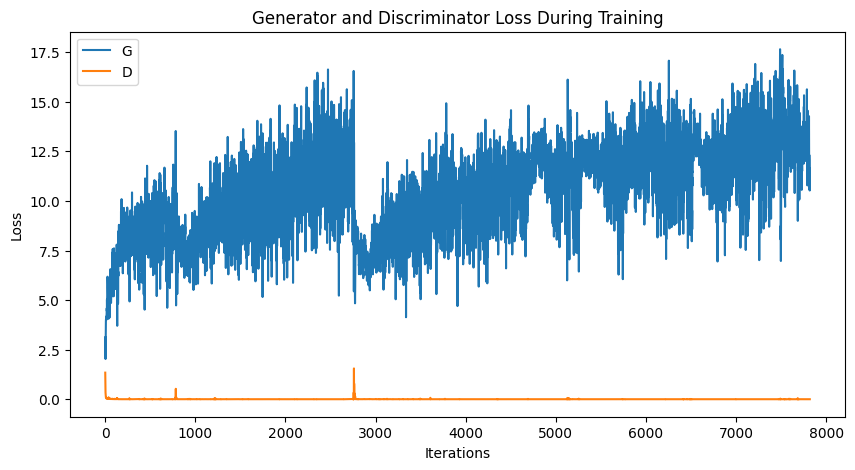

In [ ]:

# 損失の推移をプロット
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")

# 修正: .cpu().numpy() を追加
ims = [[plt.imshow(np.transpose(i.cpu().numpy(), (1, 2, 0)), animated=True)] for i in img_list]

anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())


In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

In [ ]:
# データローダから実際の画像のバッチを取得します
real_batch = next(iter(dataloader_train))

# 実際の画像をプロットします
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device)[:batch_size], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# 最後のエポックからの偽の画像をプロットします
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()


VAE-GANの学習は、VAEの再構成能力とGANの生成能力を統合するために、VAEとGANを交互に学習させる形で行われます。以下に、VAE-GANの典型的な学習プロセスを順序に従って説明します。

ステップごとの学習手順
VAEのエンコーダーとデコーダーの学習

目的: VAEのエンコーダーとデコーダーを訓練し、入力データから潜在空間へ変換（エンコード）し、そこから元データを再構成できるようにします。
損失関数: このステップでは、VAEの損失関数（MSE + KLダイバージェンス）を使用します。
学習: エンコーダーとデコーダーのパラメータを更新します。
ディスクリミネータの学習

目的: GANのディスクリミネータを訓練し、デコーダーが生成した画像と本物の画像を正確に識別できるようにします。
損失関数: ディスクリミネータに対しては、画像が「本物」または「偽物」である確率を予測させ、損失（交差エントロピー）を計算します。ディスクリミネータは以下のように訓練されます：
本物の画像: ディスクリミネータの出力が「本物」に近づくように損失を最小化。
偽の画像（デコーダーが生成した画像）: ディスクリミネータの出力が「偽物」に近づくように損失を最小化。
学習: ディスクリミネータのパラメータを更新します。
デコーダ（生成器）の学習

目的: デコーダーが生成する画像をディスクリミネータが「本物」と誤認するようにすることです。これにより、デコーダーはよりリアルな画像を生成するようになります。
損失関数: GANの損失（上記の画像に記載された
𝐿
GAN
L
GAN
​
 ）を使用します。この損失は、デコーダーが生成した画像がディスクリミネータによって「本物」と認識されるように、デコーダーのパラメータを更新します。
学習: デコーダーのパラメータを更新します（エンコーダーのパラメータは固定するか、もしくは必要に応じて更新しないこともあります）。
具体的な学習ループの流れ
次に、VAE-GANのトレーニングの流れを以下に示します。

~~~python

for epoch in range(num_epochs):
    for batch in data_loader:
        real_data = batch.to(device)

        # ステップ1: VAE（エンコーダーとデコーダー）の学習
        # エンコーダーとデコーダーの損失を計算（MSE + KLダイバージェンス）
        mu, logvar = encoder(real_data)
        z = reparameterize(mu, logvar)
        reconstructed_data = decoder(z)
        vae_loss = vae_loss_function(reconstructed_data, real_data, mu, logvar)
        
        # VAEのパラメータを更新
        vae_optimizer.zero_grad()
        vae_loss.backward()
        vae_optimizer.step()

        # ステップ2: ディスクリミネータの学習
        # 本物のデータと偽物のデータ（生成されたデータ）で損失を計算
        fake_data = decoder(torch.randn(batch_size, latent_dim).to(device)).detach()
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)
        d_loss = -torch.mean(torch.log(real_output + 1e-8) + torch.log(1 - fake_output + 1e-8))
        
        # ディスクリミネータのパラメータを更新
        discriminator_optimizer.zero_grad()
        d_loss.backward()
        discriminator_optimizer.step()

        # ステップ3: デコーダ（生成器）の学習
        # デコーダーが生成したデータが「本物」として識別されるように損失を最小化
        fake_data_for_g = decoder(z)
        fake_output_for_g = discriminator(fake_data_for_g)
        gan_loss = -torch.mean(torch.log(fake_output_for_g + 1e-8))

        # デコーダーのパラメータを更新
        decoder_optimizer.zero_grad()
        gan_loss.backward()
        decoder_optimizer.step()
~~~
要約
VAE-GANの学習手順は以下の通りです。

VAEのエンコーダーとデコーダーをMSE + KLダイバージェンス損失を使って学習します。
GANのディスクリミネータを本物と偽のデータで交差エントロピー損失を使って学習します。
GANのデコーダ（生成器）をディスクリミネータを騙せるように学習します（ディスクリミネータの損失関数の一部を使用）。
このサイクルを繰り返すことで、VAE-GANは徐々に高品質な生成と再構成の能力を得るようになります。

# 以下、不要

### ライブラリのインポート

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import HTML
from torchvision import datasets, transforms, models
from tqdm import tqdm

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## データセットの用意

In [ ]:
batch_size = 1
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)


# plane, carのデータのみ抽出する
X = []
y = []
for data in tqdm(dataset_train):
    if data[1] == 0 or data[1] == 1:
        X.append(data[0].detach().numpy().tolist())
        y.append(data[1])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

dataset_train = torch.utils.data.TensorDataset(X, y)
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=2
)

classies = ["plane", "car"]
print("データローダの作成が終わりました")

100%|██████████| 170498071/170498071 [00:01<00:00, 89485058.67it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 50000/50000 [00:26<00:00, 1886.01it/s]


データローダの作成が終わりました


## VAE-GANの定義

# WassersteinGANを用いた画像生成（PyTorch）

最後にWassersteinGANを用いたCIFAR10の画像の生成を行います。


## GANの問題点
### **Jensen Shannon Divergence(JSD)**

通常のGANは損失関数JSDを最小にすることで、真のデータ分布$P_{data}$に学習モデルのデータ分布$P_g$を近づけていきます。<br>
JSDは下記の式で表されます。
<br>
$$
JSD(P_{data}||P_g) = \frac{1}{2}KL(P_{data}||P_A) + \frac{1}{2}KL(P_g||P_A)
$$

$$
KL(P_{data}||P_g) = \int \log (\frac{P_{data}}{P_g})P_{data}d\mu(x)
$$

$$
P_A =  \frac{P_{data} + P_g}{2}
$$
<br>


JSDでは真のデータ分布と学習モデルのデータ分布が重ならない時、勾配消失問題が生じます。<br>
例として、分布が重ならない場合について考えます。$\theta$を単一のパラメータとします。真のデータ分布$P_{data}$は$\theta=0$とし$(0,z)$に存在します。学習モデルのデータ分布$P_g$は$(\theta,z)$に存在し、$\theta$を0~1の間で変化させます。(このとき$z$は一様分布$U(0,1)$に従います。)

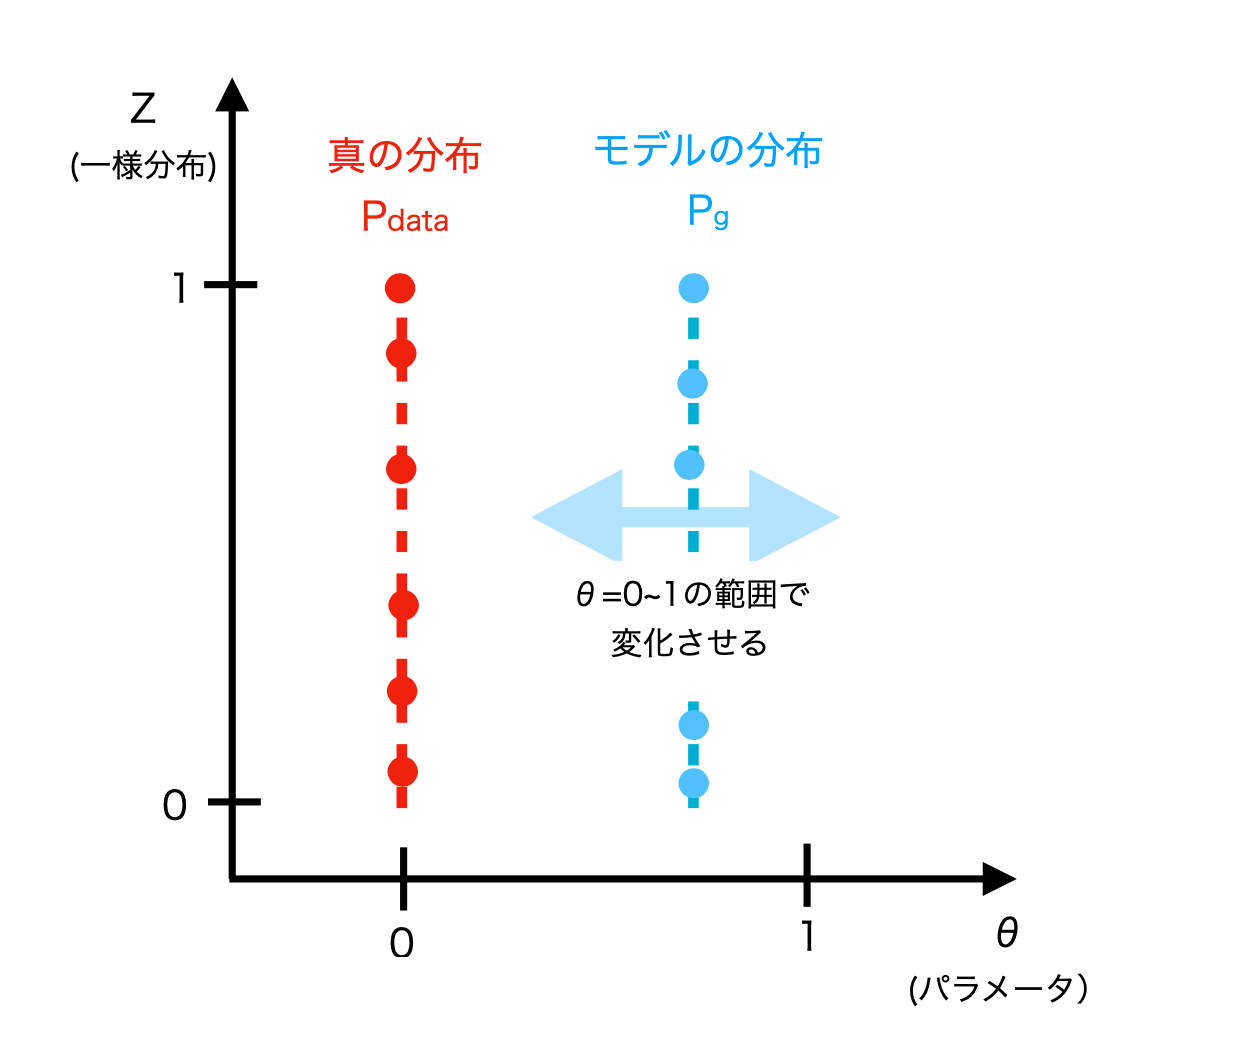


この時のJSDは以下のように計算されます。

$$
JSD(P_{data}||P_g) = \begin{cases}
\log2 & (\theta\ne  0)\\
0 & (\theta=0)
  \end{cases}
$$

この結果をグラフにすると下記になります。

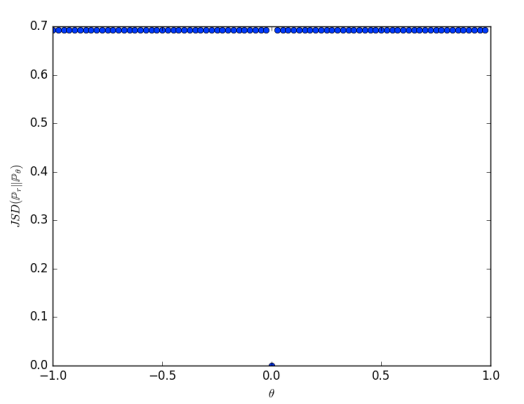 <br>
引用：https://arxiv.org/abs/1701.07875


真のデータ分布と学習モデルのデータ分布が重なる$\theta=0$のところではJSDが０となり、不連続な値になっています。<br>
一方で、真のデータ分布と学習モデルのデータ分布が重ならない$\theta\ne0$のところではJSDは値が一定となり勾配消失していることが分かります。<br>
このため、学習が不安定になったり、 **モード崩壊** を発生させることがあります。

#### ＜モード崩壊＞
モード破壊とは、学習が不十分なDiscriminatorに対してGeneratorを最適化した場合や、Generatorへの入力ノイズ z の潜在変数としての次元が足りたていない場合などにおいて、Generatorがある特定の画像しか出力しなくなる現象のことを指します。対応策の一つとして **WasseersteinGAN** が挙げられます。

### **Earth-Mover Distance(EMD) / Wasserstein距離**

WassersteinGANの特徴は損失関数としてEMD（厳密にはEMDの双対表現の近似式）が用いられている点です。<br>
EMDとは、ある分布を砂山とみなしたとき、1つの砂山$P_{data}(x)$と別の砂山$P_g(y)$の間で砂を移動するためには「どれくらいの量の砂を運ばなければならないか」を数値化した指標です。
式で表すと下記のようになります。<br>
$$
EMD(P_{data}(x)||P_g(y)) = \inf_{\gamma\in{P_{data}(x)\times P_g(y)}}E_{(x,y)\sim{\gamma}}[||x - y||]
$$

EMDについても、JSDと同様に2つの確率分布が重ならない場合を考えた時の、計算結果とグラフを下記に示します。<br>

$$
EMD(P_{data}||P_g) = |\theta|
$$

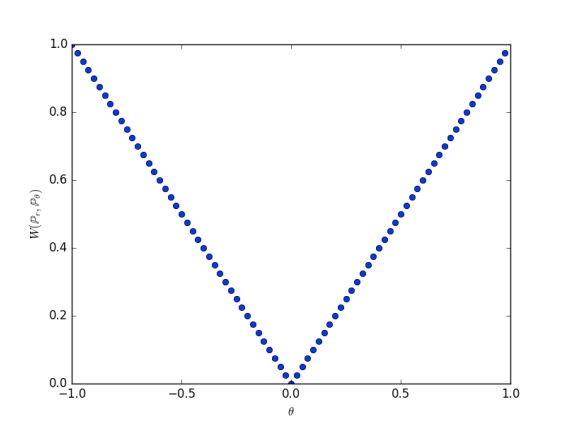<br>
引用：https://arxiv.org/abs/1701.07875
<br>
<br>
真のデータ分布と学習モデルのデータ分布が重なる$\theta=0$のところではEMDが0となります。<br>
一方で、真のデータ分布と学習モデルのデータ分布が重ならない$\theta\ne0$のところではEMDは勾配値が得られ、勾配消失していないことがわかります。<br>
<br>
ただし、WGANで実際にEMDを損失関数として使用する際、画像の次元が大きいと現実的に計算不可能なので、下記のような双対表現の近似式を損失関数として利用します。wは識別器の重みパラメータを、fは識別器の出力を示します。

$$
EMD(P_{data(x)}||P_{g(y)}) =\frac{1}{K}\max_{w\in_W}E_{x\sim{P_{data}}}[f_w(x)] - E_{x\sim{P_g}}[f_w(x)]
$$
$$
f:リプシッツ連続な関数
$$
$$
K：リプシッツ定数
$$
<br>
この際関数fはリプシッツ連続な関数であることが要求されます。<br>
リプシッツ制約を満たすための1つのテクニックとして、WGANでは識別器の重みパラメータのクリッピングが使われます。<br>

## WassersteinGANの利点
従来のGANでは損失関数JSDが勾配消失を起こすため、Generatorを１回更新→Discriminatorを１回更新と繰り返すことで学習を行なっていました。これによりDiscriminatorが学習不足となりモード崩壊が起こりやすいです。<br>
一方、WGANの損失関数EMDでは勾配が得られ続けるので、Generatorの更新１回対して、Discriminatorを複数回更新することができ、最適状態まで学習を続けることが可能となりました。これによりモード崩壊の原因となるDiscriminatorの学習不足が解消されるので、モード崩壊が発生しづらくなりました。

### データセットの用意

In [ ]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)


# plane, carのデータのみ抽出する
X = []
y = []
for data in tqdm(dataset_train):
    if data[1] == 0 or data[1] == 1:
        X.append(data[0].detach().numpy().tolist())
        y.append(data[1])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

dataset_train = torch.utils.data.TensorDataset(X, y)
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=2
)

### 生成器
生成器を実装します。<br>
今回は前述のDCGANと同様の構造です。


In [ ]:
class Generator(nn.Module):
    """生成器クラス (Generator)
    GAN（Generative Adversarial Networks）において、新しいデータを生成するネットワークを実装するクラスです。

    Attributes:
        ngpu (int): 使用するGPUの数。
        net (nn.Sequential): 生成器のニューラルネットワーク構造。

    Examples:
        >>> generator = Generator(channel_size=1, z_size=100, feature_size=64, ngpu=1)
        >>> noise = torch.randn(64, 100, 1, 1)
        >>> generated_image = generator(noise)
        >>> print(generated_image.shape)  # torch.Size([64, 1, 64, 64])

    Note:
        - このクラスは、ランダムなノイズからデータを生成するために訓練されます。
    """

    def __init__(self, channel_size, z_size, feature_size, ngpu):
        """
        生成器（Generator）クラスの初期化メソッド

        Args:
            channel_size (int): 生成される画像のチャネルサイズ。
            z_size (int): 潜在空間ベクトルのサイズ。
            feature_size (int): ネットワークの特徴量のサイズ。
            ngpu (int): 使用するGPUの数。

        Note:
            - `z_size` は、入力ノイズベクトルのサイズを定義します。
            - `feature_size` は、ネットワークの中間層のユニット数を定義します。
            - 活性化関数には `ReLU` と `Tanh` を使用します。
            - 生成される画像のサイズは `channel_size` に依存します。
        """
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_size, feature_size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_size * 2, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_size * 2, channel_size, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        """
        順伝播

        Args:
            input (torch.Tensor): 入力ノイズテンソル。形状は [batch_size, z_size, 1, 1]。

        Returns:
            torch.Tensor: 生成された画像テンソル。形状は [batch_size, channel_size, 64, 64]。

        Examples:
            # 生成器のインスタンスを作成
            generator = Generator(channel_size=1, z_size=100, feature_size=64, ngpu=1)
            # ノイズデータを準備
            noise = torch.randn(64, 100, 1, 1)
            # 生成器を使用して画像を生成
            fake_images = generator(noise)
            # 生成された画像のサイズを確認
            print(fake_images.shape)  # 出力: torch.Size([64, 1, 画像高さ, 画像幅])

        Note:
            - この関数は、入力されたノイズから画像を生成します。
            - 出力される画像のサイズは `channel_size` によって決まります。
            - `forward` 関数は、潜在空間から具体的なデータを生成するためのものです。
        """
        return self.main(input)

### 識別器
識別器を実装します。<br>
DCGANではGeneratorからの出力を受け取り、Sigmoid関数により真偽確率を算出していましたが<br>
WGANではDiscriminatorの出力の平均値をEMDの計算に使うので、Sigmoid関数は不要です。<br>
その他は前述のDCGANと同様の構造です。


In [ ]:
class Discriminator(nn.Module):
    """識別器クラス (Discriminator)
    GAN（Generative Adversarial Networks）の一部として機能し、実際のデータと生成されたデータを識別します。

    Attributes:
        ngpu (int): 使用するGPUの数。
        main (nn.Sequential): 識別器のニューラルネットワーク構造。

    Examples:
        >>> discriminator = Discriminator(channel_size=1, feature_size=64, ngpu=1)
        >>> image = torch.randn(64, 1, 28, 28)
        >>> output = discriminator(image)
        >>> print(output.shape)  # 例: torch.Size([64, 1])

    Note:
        - このクラスは、画像が実データか生成データかを識別するために訓練されます。
        - 活性化関数には `LeakyReLU` を使用します。
        - `feature_size` は、ネットワークの中間層のユニット数を定義します。
        - 最終層の出力は、画像が実データであるかどうかの確率を表します。
    """

    def __init__(self, channel_size, feature_size, ngpu):
        """
        識別器（Discriminator）クラスの初期化メソッド

        Args:
            channel_size (int): 入力チャネルのサイズ。
            feature_size (int): ネットワークの特徴量のサイズ。
            ngpu (int): 使用するGPUの数。
        """
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(channel_size, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        """
        順伝播

        Args:
            input (torch.Tensor): 入力画像テンソル。形状は [batch_size, channel_size, height, width]。

        Returns:
            torch.Tensor: 識別結果を表すテンソル。形状は [batch_size, 1]。

        Examples:
            # 識別器のインスタンスを作成
            discriminator = Discriminator(channel_size=1, feature_size=64, ngpu=1)
            # テスト用の画像データを準備
            image = torch.randn(64, 1, 28, 28)
            # 識別器を使用して識別結果を取得
            output = discriminator(image)
            # 識別結果のサイズを確認
            print(output.shape)  # 出力: torch.Size([64, 1])

        Note:
            - この関数は、入力された画像が実データか生成データかを識別します。
            - 出力されるテンソルは、各画像が実データである確率を表します。
        """
        return self.main(input)

### 学習
DCGANでは最適化アルゴリズムにAdamを用いましたが、WGANではAdamを使用すると学習が不安定になることがあるので、RMSpropを使用します。<br>
また前述の通り、損失関数関数としてEMDを用います。加えて、WGANは処理に時間がかかるのでこの試験ではDCGANよりepoch数を減らしています。（CPUで実行した場合、40~50分ほどかかりますのでご注意ください。）<br>
<br>
Discriminatorの重みパラメータを$w$、Generatorの重みパラメータを$\theta$とし、Discriminatorの真のデータに対する出力の平均値を$f_w(x)$、偽のデータに対する出力の平均値を$f_w(g_{\theta}(z))$と表すと、学習の流れは以下のようになります。<br>

1. Discriminatorの重みパラメータ$w$を$f_w(x)-f_w(g_{\theta}(z))$を最大化するように更新（=$-f_w(x)+f_w(g_{\theta}(z))$を最小化）<br>
2. Discriminatorの重みパラメータ$w$をクリッピング<br>
3. 1~2をn回繰り返し、Discriminatorを更新する。<br>
4. Generatorの重みパラメータ$\theta$を$f_w(g_{\theta}(z))$を最大化するように更新（=$-f_w(g_{\theta}(z))$を最小化）
5. 1~4を繰り返す。

注意点として、Discriminatorは$f_w(x)$を大きく、$f_w(g_{\theta}(z))$を小さくするように更新していくが必要があります。したがって，
$f_w(x)-f_w(g_{\theta}(z))$を最大化する必要があります。ただしPytorchで実装する際は損失関数の最小化問題として扱うので、マイナスをかけた値、-$f_w(x)+f_w(g_{\theta}(z))$を最小化するようにパラメータを更新していきます。またGeneratorは$f_w(g_{\theta}(z))$が大きな値となるように更新していく必要がありますが、同様に最小化問題として扱うために$-f_w(g_{\theta}(z))$を最小化するようにパラメータを更新していきます。

#### Discriminatorの損失計算
* <font color="Red">問6.```lossD```に識別器の損失計算を行う関数を記述しよう</font><br>

#### 重みのクリッピング
* <font color="Red">問7　-0.01 ＜ w ＜ 0.01の範囲でDiscriminatorの重みクリッピングを行う関数を記述しよう</font><br>
ヒント：```p.data.clamp_()```を用います。```p.data.clamp_()```は第一引数に最小値、第二引数に最大値を指定します。クリッピングの最小値は```clamp_lower```に最大値は```clamp_upper```に格納してあります。

#### Generatorの損失計算
* <font color="Red">問8. ```lossG```に生成器の損失計算を行う関数を記述しよう</font><br>

In [ ]:
ngpu = 1 #使用可能なGPUの数
channel_size = 3
feature_sizeG = 64
feature_sizeD = 64
z_size = 100

modelG = Generator(channel_size, z_size, feature_sizeG, ngpu).to(device)
modelD = Discriminator(channel_size, feature_sizeD, ngpu).to(device)

# weights_init関数を適用して重みを初期化する
modelG.apply(weights_init)
modelD.apply(weights_init)

if (device.type == 'cuda') and (ngpu > 1):
    modelG = nn.DataParallel(modelG, list(range(ngpu)))
if (device.type == 'cuda') and (ngpu > 1):
    modelD = nn.DataParallel(modelD, list(range(ngpu)))

lr = 0.00005
real_label = 1.
fake_label = 0.
clamp_lower = -0.01 #重みをクリップする際の下限
clamp_upper = 0.01 #重みをクリップする際の上限
n_critic = 3 #生成器の更新１回に対する識別器の更新回数
optimizerG = optim.RMSprop(modelG.parameters(), lr=lr)
optimizerD = optim.RMSprop(modelD.parameters(), lr=lr)
n_epochs = 50
torch.manual_seed(0)
# ジェネレータの進行を視覚化するために使用する潜在ベクトルを作成します
fixed_noise = torch.randn(batch_size, z_size, 1, 1, device=device)

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(n_epochs):
    for i, data in enumerate(dataloader_train, 0):
        for n in range(n_critic):
            #識別器ネットワークの更新
            modelD.zero_grad()
            X_train = data[0].to(device)
            b_size = X_train.size(0)
            output = modelD(X_train).view(-1)
            lossD_real = torch.mean(output)
            D_x = output.mean().item()

            #偽画像での学習
            noise = torch.randn(b_size, z_size, 1, 1, device=device)
            fake = modelG(noise)
            output = modelD(fake.detach()).view(-1)
            lossD_fake = torch.mean(output)
            D_G_z1 = output.mean().item()
            lossD = -lossD_real + lossD_fake ### 問6 ###
            lossD.backward()
            optimizerD.step()

            #重みクリッピング
            for p in modelD.parameters():
                p.data.clamp_(-0.01, 0.01) ### 問7 ###

        #生成器ネットワークの更新
        modelG.zero_grad()
        noise = torch.randn(b_size, z_size, 1, 1, device=device)
        fake = modelG(noise)
        output = modelD(fake).view(-1)
        lossG = - torch.mean(output) ### 問8 ###
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, n_epochs, i, len(dataloader_train),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # fixed_noiseによる G の出力を保存し、生成器の精度を確認します
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader_train)-1)):
            with torch.no_grad():
                fake = modelG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1


In [ ]:
# 損失推移
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

In [ ]:
# データローダから実際の画像のバッチを取得します
real_batch = next(iter(dataloader_train))

# 実際の画像をプロットします
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device)[:batch_size], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# 最後のエポックからの偽の画像をプロットします
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()